# Mid‑Project – CNN (glasses / hat / no_accessory)
*Name:* Yehonatan Ravoach

In [3]:
# ── standard python ──────────────────────────────────────────
import os
import random
import shutil
import time
import re
from pathlib import Path

# ── imaging & plotting ──────────────────────────────────────
import cv2                    # OpenCV for camera capture
import numpy as np            # numerical ops
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm         # progress-bars

# ── deep‑learning stack ─────────────────────────────────────
import torch
from torchsummary import summary
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms, utils as vutils
import torch.nn.functional as F

# ── metrics ─────────────────────────────────────────────────
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ── MediaPipe for live face detection ───────────────────────
import mediapipe as mp

# ── runtime device ──────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', device)

plt.style.use('ggplot')  # nicer plots

Using cuda


In [4]:
# Root directory that will hold raw and processed data
PROJECT_ROOT = Path.cwd()
DATA_DIR     = PROJECT_ROOT / 'data'
TRAIN_DIR    = DATA_DIR / 'train'
VAL_DIR      = DATA_DIR / 'val'
TEST_DIR     = DATA_DIR / 'test'

MODEL_DIR    = PROJECT_ROOT / 'saved_models'
MODEL_PATH   = MODEL_DIR  / 'best_model.pth'

CLASSES = ['glasses', 'hat', 'no_accessory']

In [45]:
def get_last_index(folder: Path, class_name: str) -> int:
    """Return *next* numeric index based on existing filenames <class>_<###>.jpg."""
    idxs = []
    for f in folder.glob(f'{class_name}_*.jpg'):
        try:
            idxs.append(int(f.stem.split('_')[-1]))
        except ValueError:
            pass
    return max(idxs)+1 if idxs else 0


def collect_images_from_camera(
    class_name: str,
    output_dir: Path = TRAIN_DIR,
    max_images: int = 80,
    interval: int = 5,
):
    """Capture webcam frames and save every *interval*‑th frame
    until *max_images* images are stored in *output_dir/class_name*.
    """
    save_path = output_dir / class_name
    save_path.mkdir(parents=True, exist_ok=True)

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise RuntimeError('❌ Cannot open camera')

    frame_cnt, saved_cnt = 0, 0
    next_idx = get_last_index(save_path, class_name)
    print(f"▶ Collecting '{class_name}' images  … press q to stop")

    while saved_cnt < max_images:
        ret, frame = cap.read()
        if not ret:
            print('⚠️  Frame capture failed. Exiting.')
            break

        # show live feed
        cv2.imshow('Capture', frame)

        # save every Nth frame
        if frame_cnt % interval == 0:
            fname = save_path / f"{class_name}_{next_idx:03d}.jpg"
            cv2.imwrite(str(fname), frame)
            saved_cnt += 1
            next_idx += 1

        frame_cnt += 1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    print(f'✔ Collected {saved_cnt} images → {save_path}')

In [46]:
#collect_images_from_camera("no_accessory", max_images=80, interval=5)

In [47]:
#collect_images_from_camera("glasses", max_images=80, interval=5)

In [48]:
#collect_images_from_camera("hat", max_images=80, interval=5)

In [49]:
def rename_images_in_order(folder: Path, class_name: str, start_from:int = 1):
    """Ensure filenames are sequential: <class>_001.jpg, 002, …"""
    files = sorted([f for f in folder.glob(f"{class_name}_*.jpg")])

    # Temporary rename (avoid collision)
    for i,old in enumerate(files):
        old.rename(folder / f"tmp_{i:04d}.jpg")

    # Final rename
    tmp_files = sorted(folder.glob('tmp_*.jpg'))
    for i,tmp in enumerate(tmp_files, start=start_from):
        tmp.rename(folder / f"{class_name}_{i:03d}.jpg")

    print(f'✔ {len(tmp_files)} files renamed in {folder}')

In [50]:
#rename_images_in_order("train/hat", "hat")

In [51]:
#rename_images_in_order("train/glasses", "glasses")

In [52]:
#rename_images_in_order("train/no_accessory", "no_accessory")

In [53]:
#Step 1: Split data into train/val with balanced shuffling
def split_dataset(train_dir, val_dir, test_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    train_dir = Path(train_dir)
    val_dir = Path(val_dir)
    test_dir = Path(test_dir)

    # Ensure the ratios sum to 1.0
    assert abs((train_ratio + val_ratio + test_ratio) - 1.0) < 1e-5, "Ratios must sum to 1.0"

    classes = [d.name for d in train_dir.iterdir() if d.is_dir()]

    for class_name in classes:
        class_folder = train_dir / class_name
        images = list(class_folder.glob("*.jpg"))
        random.shuffle(images)

        total = len(images)
        train_end = int(total * train_ratio)
        val_end = train_end + int(total * val_ratio)

        train_images = images[:train_end]
        val_images = images[train_end:val_end]
        test_images = images[val_end:]

        # Create destination folders
        val_class_folder = val_dir / class_name
        test_class_folder = test_dir / class_name
        val_class_folder.mkdir(parents=True, exist_ok=True)
        test_class_folder.mkdir(parents=True, exist_ok=True)

        # Move val images
        for img in val_images:
            shutil.move(str(img), val_class_folder / img.name)

        # Move test images
        for img in test_images:
            shutil.move(str(img), test_class_folder / img.name)

    print("Dataset split into train/val/test complete.")

In [54]:
# split_dataset(
#     train_dir=TRAIN_DIR,
#     val_dir=VAL_DIR,
#     test_dir=TEST_DIR,
#     train_ratio=0.7,
#     val_ratio=0.15,
#     test_ratio=0.15
# )

Train counts: {'glasses': 1260, 'hat': 1260, 'no_accessory': 1260}
Val   counts: {'glasses': 90, 'hat': 90, 'no_accessory': 90}
Test  counts: {'glasses': 90, 'hat': 90, 'no_accessory': 90}


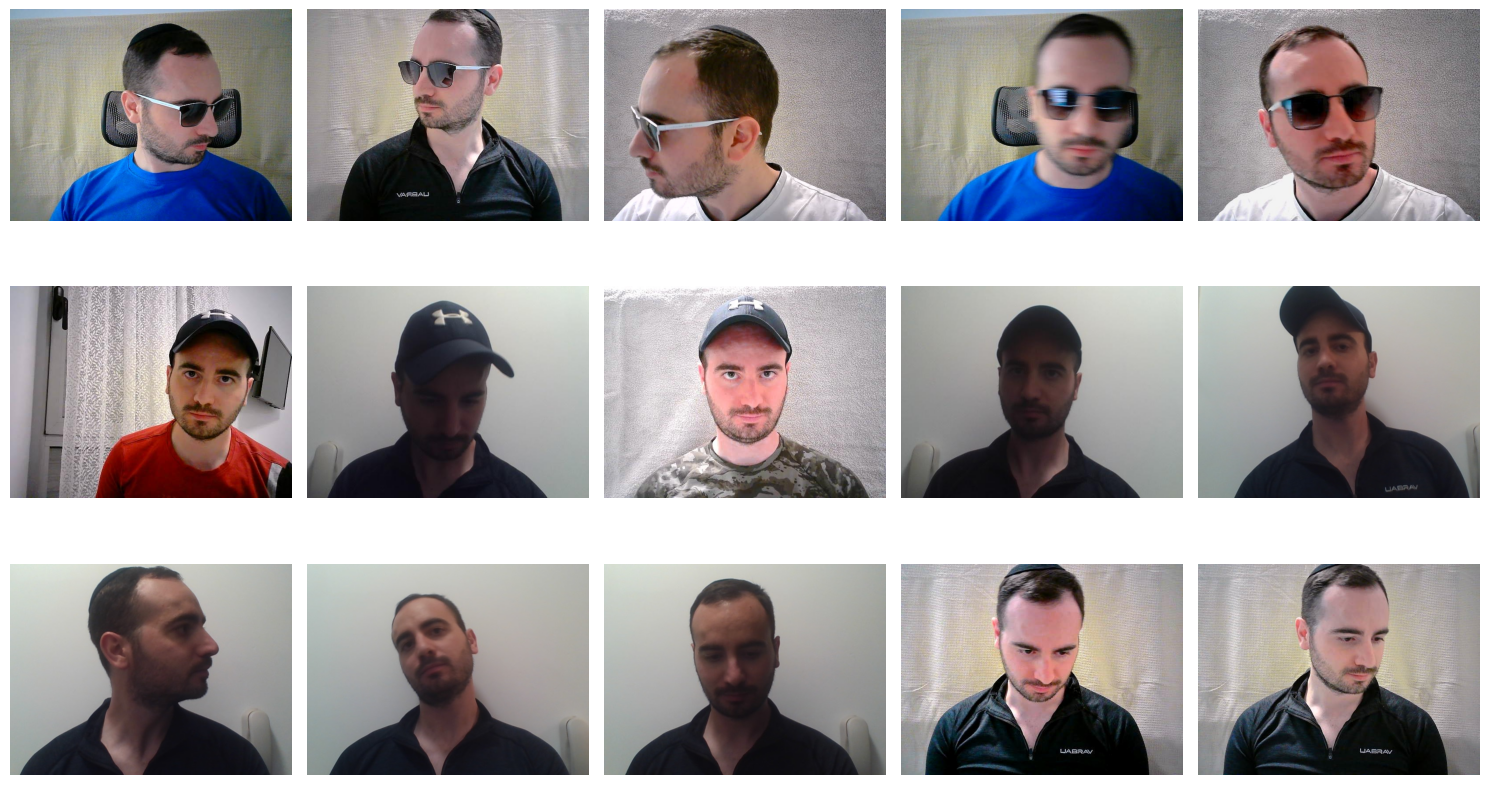

In [3]:
def count_images(folder: Path):
    return {cls: len(list((folder/cls).glob('*.jpg'))) for cls in CLASSES}

print('Train counts:', count_images(TRAIN_DIR))
print('Val   counts:', count_images(VAL_DIR))
print('Test  counts:', count_images(TEST_DIR))


def plot_samples(folder: Path, n=5):
    """Display *n* random images per class."""
    fig, axes = plt.subplots(len(CLASSES), n, figsize=(n*3, len(CLASSES)*3))
    for r,cls in enumerate(CLASSES):
        imgs = random.sample(list((folder/cls).glob('*.jpg')), n)
        for c,img_path in enumerate(imgs):
            ax = axes[r][c]
            ax.imshow(Image.open(img_path))
            ax.axis('off')
            if c==0:
                ax.set_ylabel(cls, fontsize=14)
    plt.tight_layout(); plt.show()

plot_samples(TRAIN_DIR)

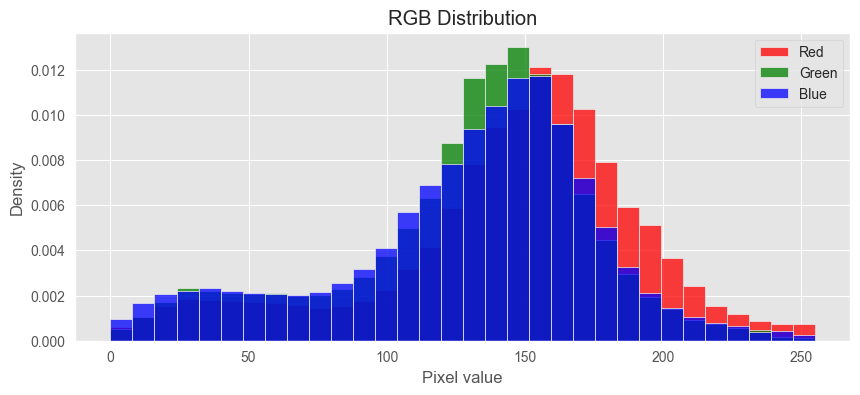

In [56]:
def plot_rgb_distribution(folder:Path, samples_per_class:int=100):
    """Plot combined RGB histogram for a subset of images."""
    pixels = []
    for cls in CLASSES:
        imgs = list((folder/cls).glob('*.jpg'))[:samples_per_class]
        for img_path in imgs:
            img = Image.open(img_path).convert('RGB').resize((64,64))
            pixels.append(np.array(img).reshape(-1,3))
    pixels = np.concatenate(pixels, axis=0)
    r,g,b = pixels[:,0], pixels[:,1], pixels[:,2]

    plt.figure(figsize=(10,4))
    sns.histplot(r, color='red',   label='Red',   bins=32, stat='density');
    sns.histplot(g, color='green', label='Green', bins=32, stat='density');
    sns.histplot(b, color='blue',  label='Blue',  bins=32, stat='density');
    plt.title('RGB Distribution'); plt.xlabel('Pixel value'); plt.legend(); plt.show()

plot_rgb_distribution(TRAIN_DIR)

In [57]:
# augmentations = [
#     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
#     transforms.RandomHorizontalFlip(p=1.0)
# ]
#
# for category in os.listdir(TRAIN_DIR):
#     category_path = os.path.join(TRAIN_DIR, category)
#     if not os.path.isdir(category_path):
#         continue
#
#     images = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
#
#     for idx, img_name in enumerate(tqdm(images, desc=f"Processing {category}")):
#         img_path = os.path.join(category_path, img_name)
#         try:
#             image = Image.open(img_path).convert("RGB")
#         except Exception as e:
#             print(f"Skipping {img_path}: {e}")
#             continue
#
#         for i, aug in enumerate(augmentations):
#             augmented = aug(image)
#             new_name = f"{os.path.splitext(img_name)[0]}_aug{i+1}.jpg"
#             new_path = os.path.join(category_path, new_name)
#             augmented.save(new_path)


In [5]:
mean, std = [0.5]*3, [0.5]*3

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

In [6]:
batch_size=64
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
print(idx_to_class)

{0: 'glasses', 1: 'hat', 2: 'no_accessory'}


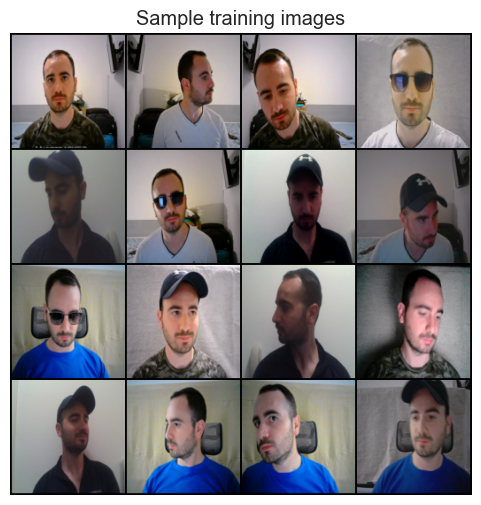

In [21]:
imgs,_ = next(iter(train_loader))
# Build a 4×4 preview grid
grid = vutils.make_grid(
    imgs[:16],       # first 16 images of the batch
    nrow=4,          # 4 images per row
    normalize=True,  # map [-1,1] → [0,1] for display
    value_range=(-1,1)
)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0))
plt.axis('off')
plt.title('Sample training images');
plt.show()

In [7]:
# CNN architecture for input images of size 128x128x3 and 3 Accessory classes
class AccessoryCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(AccessoryCNN, self).__init__()

        # Block 1: Conv -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)    # Output: 32 x 128 x 128
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                                  # Output: 32 x 64 x 64

        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)                            # Output: 64 x 64 x 64
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                                  # Output: 64 x 32 x 32

        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)                           # Output: 128 x 32 x 32
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)                                  # Output: 128 x 16 x 16

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [8]:
# Instantiate model and move to CPU
model = AccessoryCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Show model summary
summary(model, input_size=(3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Linear-7                  [-1, 256]       8,388,864
           Dropout-8                  [-1, 256]               0
            Linear-9                    [-1, 3]             771
Total params: 8,482,883
Trainable params: 8,482,883
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 8.75
Params size (MB): 32.36
Estimated Total Size (MB): 41.30
-------------------------------------

### 🧠 CNN Architecture Summary

| Layer          | Input Shape        | Output Shape       | Parameters |
|----------------|--------------------|---------------------|------------|
| Conv2D (3→32)  | [3, 128, 128]      | [32, 128, 128]      | 896        |
| MaxPool2D      | [32, 128, 128]     | [32, 64, 64]        | 0          |
| Conv2D (32→64) | [32, 64, 64]       | [64, 64, 64]        | 18,496     |
| MaxPool2D      | [64, 64, 64]       | [64, 32, 32]        | 0          |
| Conv2D (64→128)| [64, 32, 32]       | [128, 32, 32]       | 73,856     |
| MaxPool2D      | [128, 32, 32]      | [128, 16, 16]       | 0          |
| Flatten        | [128, 16, 16]      | [32,768]            | 0          |
| FC1            | [32,768]           | [256]               | 8,388,864  |
| ReLU           | [256]              | [256]               | 0          |
| FC2            | [256]              | [3]                 | 771        |

**Total Parameters:** ≈ 8.5 million

In [21]:
model = AccessoryCNN(num_classes=3)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
num_epochs = 8

In [22]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    scheduler.step()

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_PATH)
        print("Best model saved!")



Epoch [1/8] | Train Acc: 0.6606 | Val Acc: 0.7778 | Train Loss: 43.1636 | Val Loss: 2.3217
Best model saved!
Epoch [2/8] | Train Acc: 0.8854 | Val Acc: 0.8704 | Train Loss: 19.2164 | Val Loss: 1.1622
Best model saved!
Epoch [3/8] | Train Acc: 0.9331 | Val Acc: 0.9704 | Train Loss: 11.0813 | Val Loss: 0.6842
Best model saved!
Epoch [4/8] | Train Acc: 0.9743 | Val Acc: 0.9889 | Train Loss: 5.0259 | Val Loss: 0.4258
Best model saved!
Epoch [5/8] | Train Acc: 0.9844 | Val Acc: 0.9815 | Train Loss: 3.0446 | Val Loss: 0.4244
Epoch [6/8] | Train Acc: 0.9881 | Val Acc: 0.9889 | Train Loss: 2.3746 | Val Loss: 0.3448
Epoch [7/8] | Train Acc: 0.9907 | Val Acc: 0.9889 | Train Loss: 1.8019 | Val Loss: 0.3755
Epoch [8/8] | Train Acc: 0.9950 | Val Acc: 0.9926 | Train Loss: 1.3020 | Val Loss: 0.3438
Best model saved!


In [27]:
#torch.save(model.state_dict(), MODEL_PATH)

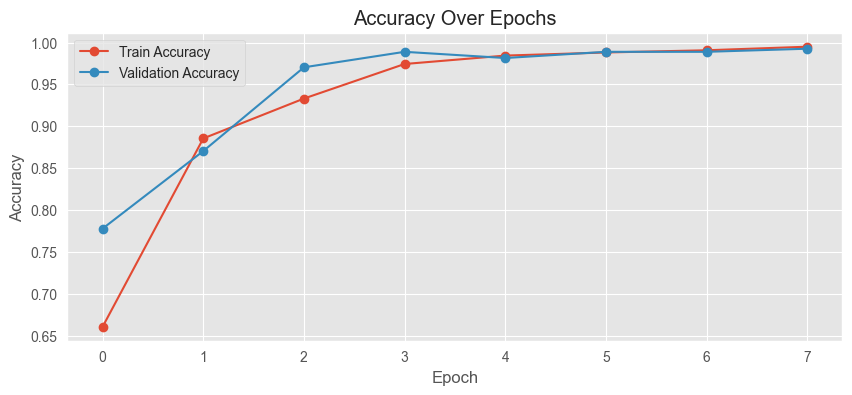

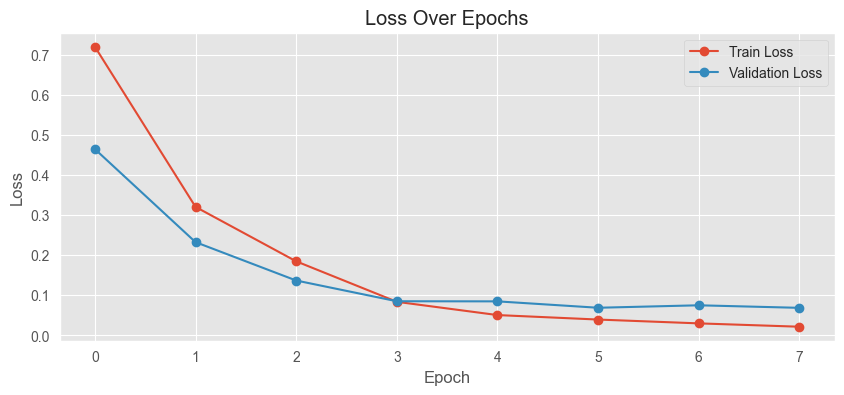

In [23]:
# Accuracy
plt.figure(figsize=(10, 4))
plt.plot(train_accuracies,'-o', label='Train Accuracy')
plt.plot(val_accuracies,'-o', label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses,'-o', label='Train Loss')
plt.plot(val_losses,'-o', label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
model = AccessoryCNN(num_classes=3)
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)
model.eval()

AccessoryCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)

In [12]:
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.9926


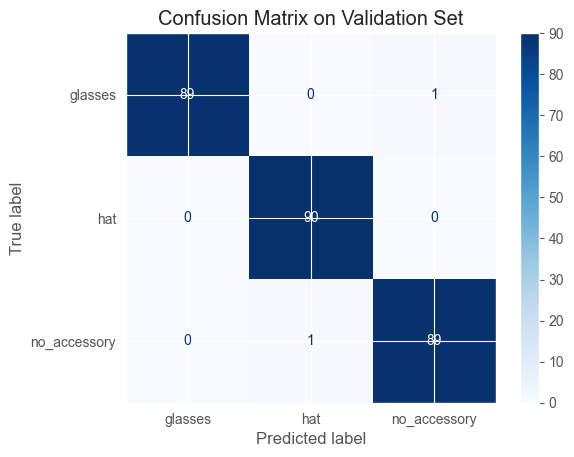

In [12]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(train_dataset.class_to_idx.keys()))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Validation Set")
plt.show()


In [9]:
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Test loading
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = correct / total
print(f"✅ Test Accuracy: {test_accuracy:.4f}")


✅ Test Accuracy: 0.9963


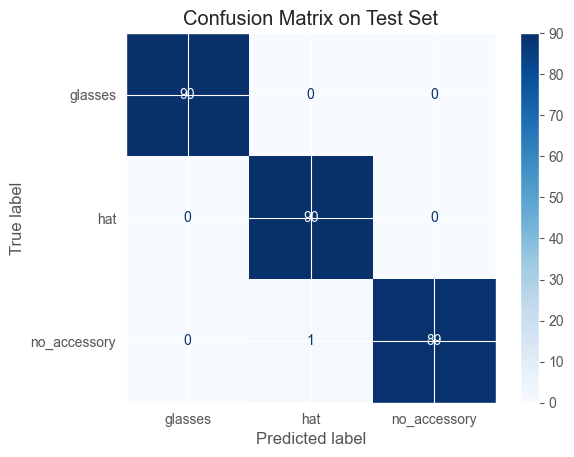

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(train_dataset.class_to_idx.keys()))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.show()


In [10]:
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
print(train_dataset.class_to_idx)

{'glasses': 0, 'hat': 1, 'no_accessory': 2}


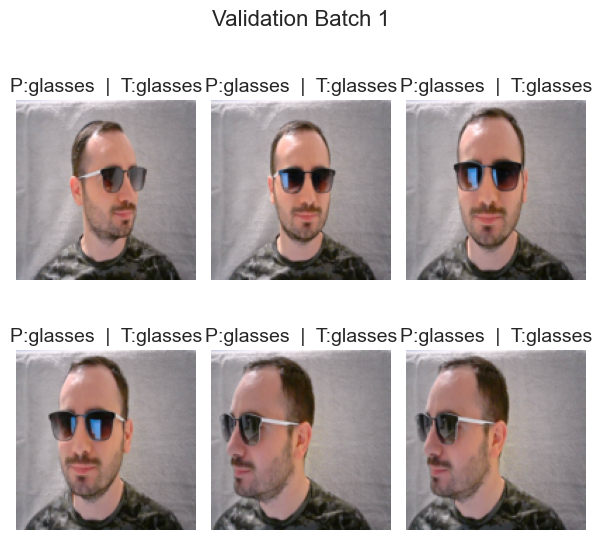

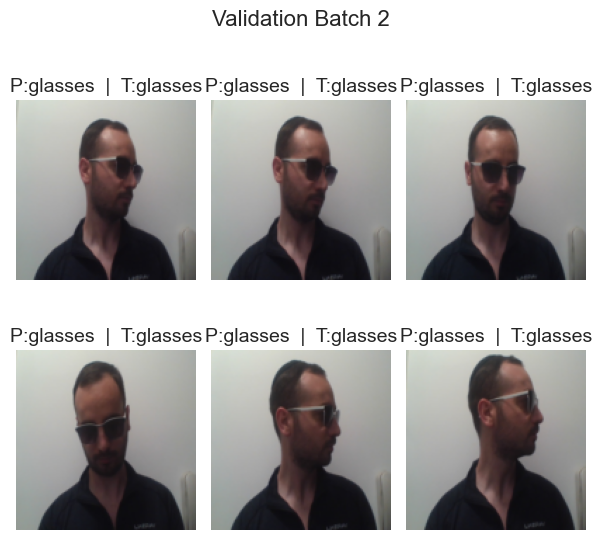

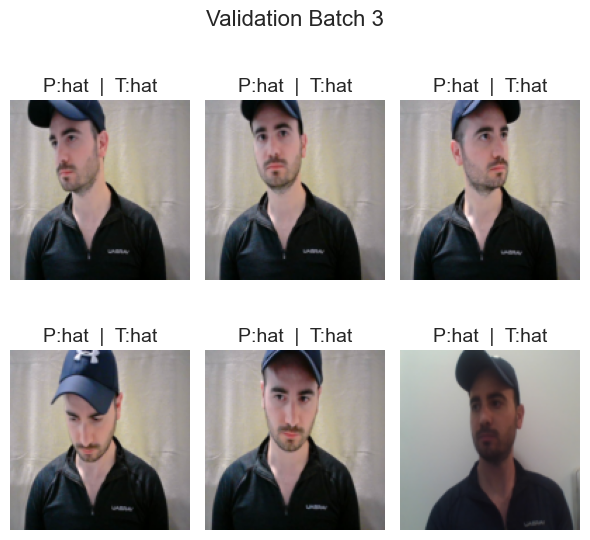

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AccessoryCNN().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

classes = idx_to_class          # {0:'glasses', 1:'hat', 2:'no_accessory'}

def show_val_batches(loader, n_batches=3):
    it = iter(loader)
    for b in range(n_batches):
        imgs, labels = next(it)
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            preds = model(imgs).argmax(dim=1)

        # ---- take first 4 samples ----
        imgs4   = imgs[:6].cpu()
        labels4 = labels[:6].cpu()
        preds4  = preds [:6].cpu()

        # ---- plot 2×2 grid ----
        fig, axes = plt.subplots(2, 3, figsize=(6, 6))
        axes = axes.flatten()
        for ax, img, y_true, y_pred in zip(axes, imgs4, labels4, preds4):
            # denorm  (-1,1) → (0,1)
            img = (img * 0.5 + 0.5).permute(1, 2, 0).clamp(0, 1).numpy()
            ax.imshow(img)
            ax.set_title(f"P:{classes[y_pred.item()]}  |  T:{classes[y_true.item()]}",
                         fontsize=14)
            ax.axis('off')

        fig.suptitle(f"Validation Batch {b+1}", fontsize=16)
        plt.tight_layout()
        plt.show()

# call it
show_val_batches(val_loader, n_batches=3)


In [18]:


model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device("cpu")))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
#idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}

# MediaPipe Initialize
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.7)

# ✅ Camera capture
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Could not open webcam.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_flipped = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame_flipped, cv2.COLOR_BGR2RGB)

    results = face_detection.process(rgb_frame)

    label = "No face"
    if results.detections:
        for detection in results.detections:
            bboxC = detection.location_data.relative_bounding_box
            h, w, _ = frame_flipped.shape
            x = int(bboxC.xmin * w)
            y = int(bboxC.ymin * h)
            width = int(bboxC.width * w)
            height = int(bboxC.height * h)

            y = max(y - int(0.6 * height), 0)
            height = height + int(0.6 * height)

            # crop
            face_crop = frame_flipped[y:y+height, x:x+width]
            face_bgr = Image.fromarray(cv2.resize(face_crop, (128, 128)))       # for later example what is BGR
            face_pil = Image.fromarray(cv2.cvtColor(cv2.resize(face_crop, (128, 128)), cv2.COLOR_BGR2RGB))
            tensor = transform(face_pil).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(tensor)
                _, predicted = torch.max(output, 1)
                label = idx_to_class[predicted.item()]

            # Display
            cv2.rectangle(frame_flipped, (x, y), (x+width, y+height), (0, 255, 0), 2)
            cv2.putText(frame_flipped, label, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)
            break

    cv2.imshow('Accessory Detection (MediaPipe)', frame_flipped)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


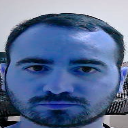

In [19]:
face_bgr